In [1]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Vertical balancing of an acrobot using DIRCOL

In [2]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
Pkg.add("PyPlot")
Pkg.add("LinearAlgebra")
Pkg.add("ForwardDiff")
Pkg.add("RobotZoo")
Pkg.add("RobotDynamics")
Pkg.add("Ipopt")
Pkg.add("MathOptInterface")
using LinearAlgebra, PyPlot
using ForwardDiff
using RobotZoo
const RZ = RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
const MOI = MathOptInterface;

  Activating project at `~/Documents/Optimal_Control/Sims/Direct_Collocation`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
    Updating `~/Documents/Optimal_Control/Sims/Direct_Collocation/Manifest.toml`
⌃ [b53b4c65] ↑ libpng_jll v1.6.38+0 ⇒ v1.6.38+1
        Info Packages marked with ⌃ have new versions available and may be upgradable.
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
  No Changes t

In [3]:
#Pendulum Dynamics
a = RobotZoo.Acrobot()
h = 0.1 #10Hz

0.1

In [4]:
Nx = 4 #number of states
Nu = 1 #number of controls
Tfinal = 5.0 #final time
Nt = Int(Tfinal/h)+1 #number of time steps
thist = Array(range(0, h*(Nt-1), step=h));
n_nlp = (Nx+Nu)*Nt #number of decision variables
m_nlp = Nx*(Nt+1)

208

In [5]:
function dircol_dynamics(x1,u1,x2,u2)
    #Hermite-Simpson integration with first-order hold on u
    f1 = RZ.dynamics(a, x1, u1)
    f2 = RZ.dynamics(a, x2, u2)
    xm = 0.5*(x1 + x2) + (h/8.0)*(f1 - f2)
    um = 0.5*(u1 + u2)
    ẋm = (-3/(2.0*h))*(x1 - x2) - 0.25*(f1 + f2)
    fm = RZ.dynamics(a, xm, um)
    return fm - ẋm
end

dircol_dynamics (generic function with 1 method)

In [6]:
#Cost weights
Q = Diagonal([1.0*ones(2); 1.0*ones(2)]);
R = 0.1;

In [7]:
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*u'*R*u
end

stage_cost (generic function with 1 method)

In [8]:
function cost(ztraj)
    z = reshape(ztraj, Nx+Nu, Nt)
    J = 0.0
    for k=1:Nt
        J += stage_cost(z[1:Nx,k],z[(Nx+1):(Nx+Nu),k])
    end
    return J
end

cost (generic function with 1 method)

In [9]:
function dynamics_constraint!(c,ztraj)
    d = reshape(c, Nx, Nt-1)
    z = reshape(ztraj, Nx+Nu, Nt)
    for k = 1:(Nt-1)
        x1 = z[1:Nx,k]
        u1 = z[(Nx+1):(Nx+Nu),k]
        x2 = z[1:Nx,k+1]
        u2 = z[(Nx+1):(Nx+Nu),k+1]
        d[:,k] = dircol_dynamics(x1,u1,x2,u2)
    end
    return nothing
end

dynamics_constraint! (generic function with 1 method)

In [10]:
function con!(c,ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)
    c[1:Nx] .= z[1:Nx,1] - x0
    @views dynamics_constraint!(c[(Nx+1):(end-Nx)],ztraj)
    c[(end-Nx+1):end] .= z[1:Nx,end] - xgoal
end

con! (generic function with 1 method)

In [11]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_l[idx_ineq] .= -Inf

    c_u = zeros(m)
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        MOI.add_constraint(solver, x[i], MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, x[i], MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

solve (generic function with 1 method)

In [12]:
#Initial and goal states
x0 = [-pi/2; 0; 0; 0]
xgoal = [pi/2; 0; 0; 0]
xtraj = kron(ones(1,Nt), x0);

In [13]:
#Guess
xguess = kron(ones(Nt)', x0)
xguess[1,:] .= xtraj[1,:] + 0.1*randn(Nt)
uguess = zeros(Nt)'
z0 = reshape([xguess; uguess],(Nx+Nu)*Nt,1);

In [14]:
prob = ProblemMOI(n_nlp, m_nlp)
z_sol = solve(z0,prob) #solve
ztraj = reshape(z_sol,Nx+Nu,Nt)
xtraj = ztraj[1:Nx,:]
utraj = ztraj[(Nx+1):(Nx+Nu),:];


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    53040
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

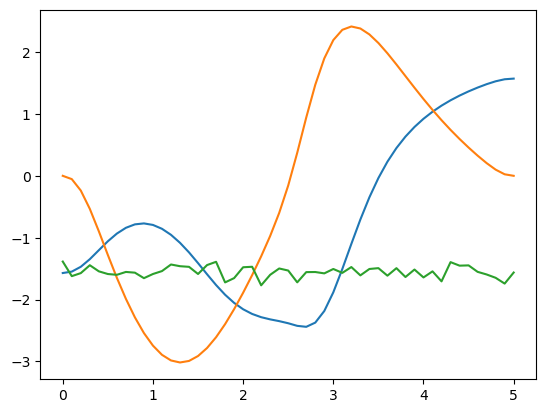

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5d2d48c8b0>

In [15]:
plot(thist, xtraj[1,:])
plot(thist, xtraj[2,:])
plot(thist, xguess[1,:])

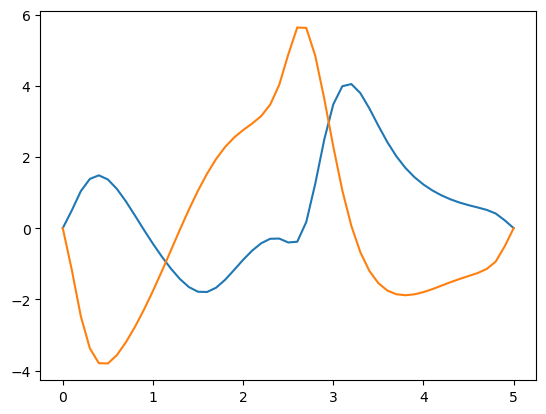

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5d2c4e0fa0>

In [16]:
plot(thist, xtraj[3,:])
plot(thist, xtraj[4,:])

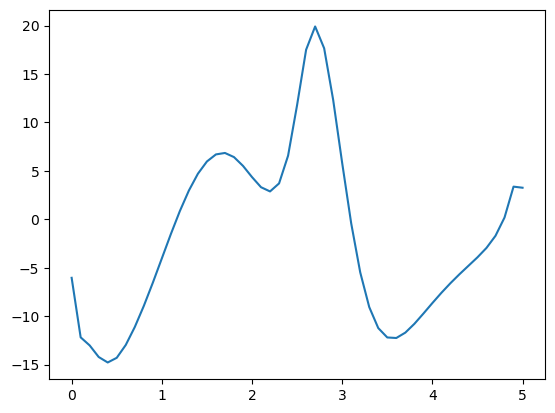

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5d2c459f10>

In [17]:
plot(thist,utraj[1,:])

In [18]:
Pkg.add("TrajOptPlots")
Pkg.add("MeshCat")
Pkg.add("StaticArrays")
using TrajOptPlots
using MeshCat
using StaticArrays

   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Direct_Collocation/Manifest.toml`
[ Info: Precompiling TrajOptPlots [7770976a-8dee-4930-bf39-a1782fd21ce6]


In [19]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8702))

In [20]:
TrajOptPlots.set_mesh!(vis, a)

MeshCat Visualizer with path /meshcat/robot/link1/joint at http://127.0.0.1:8702

In [22]:
X1 = [SVector{4}(x) for x in eachcol(xtraj)];
visualize!(vis, a, thist[end], X1)